## Notebook to test ocean and land flag

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import re
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC 
import tensorflow as tf
from tensorflow.data.experimental import parallel_interleave

In [3]:
libdir = '/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from lib_modis02 import proc_sds

### Cloud Mask Bit in MOD06/MOD35  [6-7bits] statrt from 0
https://atmosphere-imager.gsfc.nasa.gov/products/cloud/format-content  
https://atmosphere-imager.gsfc.nasa.gov/products/cloud-mask/format-content

In [4]:
# 3d array version [6,ix,iy]
def _decode_cloud_flag(sds_array, fillna=True):
    """ Assume sds_array = hdf.select('Cloud_Mask') [6,nx,ny]
         File: Cloud_Mask_1.hdf which stores first important 6bits

         +Flags
         0: 00 = water
         1: 01 = coastal
         2: 10 = desert
         3: 11 = land
    """
    def bits_stripping(bit_start,bit_count,value):
        bitmask=pow(2,bit_start+bit_count)-1
        return np.right_shift(np.bitwise_and(value,bitmask),bit_start)
    cm_array = sds_array.get()
    _, nx, ny = cm_array.shape
    print(cm_array.shape)
    carray = np.zeros((nx,ny))
    for ix in range(nx):
        for iy in range(ny):
            # Shown below is the first byte only, of the six byte Cloud Mask
            # cm_array[index,ix,iy] : index should be 0 but get 6-7 bits of first  byte 
            cloud_mask_flag = bits_stripping(6,7,cm_array[0,ix,iy])
            carray[ix, iy] = cloud_mask_flag
    ncarray = carray.astype(np.float64)
    if fillna:
        nan_idx = np.where(cm_array[0] == sds_array.attributes()['_FillValue'])
        ncarray[nan_idx] = np.nan
    return ncarray

In [22]:
# 2d array version [6,ix,iy]
def decode_cloud_flag(sds_array, fillna=True):
    """ Assume sds_array = hdf.select('Cloud_Mask') [6,nx,ny]
         File: Cloud_Mask_1.hdf which stores first important 6bits

         +Flags
         0: 00 = water
         1: 01 = coastal
         2: 10 = desert
         3: 11 = land
    """
    def bits_stripping(bit_start,bit_count,value):
        bitmask=pow(2,bit_start+bit_count)-1
        return np.right_shift(np.bitwise_and(value,bitmask),bit_start)
    cm_array = sds_array.get()
    nx, ny = cm_array.shape
    print(cm_array.shape)
    carray = np.zeros((nx,ny))
    for ix in range(nx):
        for iy in range(ny):
            # Shown below is the first byte only, of the six byte Cloud Mask
            # cm_array[index,ix,iy] : index should be 0 but get 6-7 bits of first  byte 
            cloud_mask_flag = bits_stripping(6,7,cm_array[ix,iy])
            carray[ix, iy] = cloud_mask_flag
    ncarray = carray.astype(np.float64)
    if fillna:
        nan_idx = np.where(cm_array[0] == sds_array.attributes()['_FillValue'])
        ncarray[nan_idx] = np.nan
    return ncarray

### Load data: Try on RGB data

In [5]:
def zscore(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))

-------------------------------
### Load MOD06 data for flag
Ref: https://moonbooks.org/Codes/Plot-MODIS-C6-Cloud-Mask-1km-with-python-and-matplotlib/
Userguide: https://atmosphere-imager.gsfc.nasa.gov/sites/default/files/ModAtmo/CMUSERSGUIDE_0.pdf

In [14]:
hdf_datadir2 = "/home/tkurihana/clouds/analysis_mod021KM/data/MOD35"
#'/project2/foster/clouds/data/MOD35_part2'

In [15]:
m35_file = "MOD35_L2.A2015335.mosaic.061.2019271230454.psmcgscs_000501379738.Cloud_Mask_1.hdf"
#'MOD35_L2.A2018095.1705.061.2018096013818.hdf' #/project2/foster/clouds/data/MOD35_part2

In [16]:
filename = os.path.join(hdf_datadir2, m35_file)

In [17]:
filename

'/home/tkurihana/clouds/analysis_mod021KM/data/MOD35/MOD35_L2.A2015335.mosaic.061.2019271230454.psmcgscs_000501379738.Cloud_Mask_1.hdf'

In [18]:
#hdf_data.select(variable_name)
flag_sds = SD(filename, SDC.READ)

In [ ]:
flag_sds.datasets()

#### cloud mask 1km
##### MOD06
 'Cloud_Mask_1km': (('Cell_Along_Swath_1km:mod06',  
   'Cell_Across_Swath_1km:mod06',  
   'Cloud_Mask_1km_Num_Bytes:mod06'),  
  (2030, 1354, 2),  
  20,  
  112),  
  
##### MOD35
 'Cloud_Mask': (('Byte_Segment:mod35',  
   'Cell_Along_Swath_1km:mod35',  
   'Cell_Across_Swath_1km:mod35'),  
  (6, 2030, 1354),  
  20,  
  8),  

In [19]:
fsds_array = flag_sds.select('Cloud_Mask')

In [21]:
fsds_array.get().shape

(3562, 3540)

In [23]:
#olflags = _decode_cloud_flag(fsds_array) ### if MOD35_L2.A2018095.1705.061.2018096013818.hdf
olflags = decode_cloud_flag(fsds_array)  ### if mosaic file

(3562, 3540)


----------------------
### Visualize land/ocean flag

- MOD35_L2.A2018095.1705.061.2018096013818.hdf

In [12]:
olflags.shape

(2030, 1354)

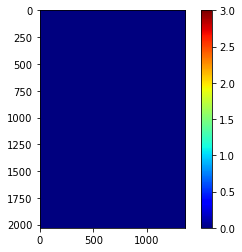

In [13]:
plt.figure()
plt.imshow(olflags, cmap='jet', vmin=0, vmax=3)
plt.colorbar()
plt.show()

- MOD35_L2.A2015335.mosaic.061.2019271230454.psmcgscs_000501379738.Cloud_Mask_1.hdf

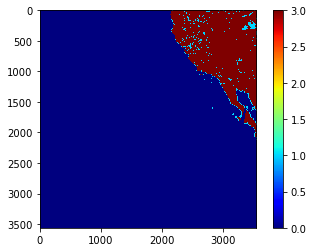

In [24]:
"""
         +Flags
         0: 00 = water
         1: 01 = coastal
         2: 10 = desert
         3: 11 = land
"""
plt.figure()
plt.imshow(olflags, cmap='jet', vmin=0, vmax=3)
plt.colorbar()
plt.show()